# Численное решение задачи для нелинейного уравнения теплопроводности

> <span style="font-style:normal; font-size:12pt;"> 
        <ol> 
            <li> Решить нелинейное уравнение теплопроводности на полубесконечной прямой по неявной схеме. Коэффициент теплопроводности имеет степенную форму (лучистая теплопроводность). На левой границе температура задана.  </li>
            <li> Сравнить решение с аналитическим (или приближенным) решением. </li>
        </ol> 
    <p> В качестве аналитических решений используются решения, приведенные в статье Н.А. Кудряшова, Приближенные решения одной задачи нелинейной теплопроводности. </p>

<span style="font-style:normal; font-size:14pt;"> 

$$
\begin{cases}
\frac{\partial{u}}{\partial{t}} = \frac{\partial}{\partial{t}}[\lambda(u)\frac{\partial{u}}{\partial{x}}], \ \ 0 < x,  \ \ 0 < t\\
u(0,t) = \mu(t),                            \\
u(x,0) = 0.                                 \\ 
\end{cases}
$$

$$
\begin{equation}
\lambda(u) = u^{n}
\end{equation}
$$

In [1]:
%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib.widgets   import Slider, Button
from matplotlib           import cm
import numpy as np

# from mpl_toolkits.mplot3d import axes3d

In [2]:
# Метод прогонки для решения СЛАУ
def Thomas_algorithm(a_plot, b_plot, c_plot, f_plot):
    
    n = len(f_plot)
    y_plot = []
        
    A_plot = []
    B_plot = []
    
    A0 = (-1) * c_plot[0] / b_plot[0]
    B0 = f_plot[0] / b_plot[0]
    
    A_plot.append(A0)
    B_plot.append(B0)
    
    for i in range(1, n - 1):
        Ai = (-1) * c_plot[i] / (b_plot[i] + a_plot[i] * A_plot[i - 1])
        A_plot.append(Ai)
    
    for i in range(1, n):
        Bi = (f_plot[i] - a_plot[i] * B_plot[i - 1]) / (b_plot[i] + a_plot[i] * A_plot[i - 1])
        B_plot.append(Bi)
    
    An = 0   
    A_plot.append(An)    
    
    y_plot.append(B_plot[n - 1])
    
    for i in range(n - 2, -1, -1):
        yi = B_plot[i] + A_plot[i] * y_plot[0]
        y_plot.insert(0, yi)
    
    return y_plot

In [3]:
# Вычисление констант СЛАУ (апроксимация)
def SLE_constants(x_plot, t, t_i, apprx_layer_s, prev_layer, 
                  kappa, N, u0, K):
    
    m = len(x_plot)
   
    h = x_plot[1] - x_plot[0]
    
    a_plot = []
    b_plot = []
    c_plot = []
    f_plot = []
    
    c  = t / (2 * h**2) 
    a0, b0, c0, f0, am, bm, cm, fm = 0, 0, 0, 0, 0, 0, 0, 0
    
    a0 = 0
    b0 = 1
    c0 = 0
    f0 = u0 * t_i**K
    
    am = 0 
    bm = 1
    cm = 0
    fm = 0

    a_plot.append(a0)
    b_plot.append(b0)
    c_plot.append(c0)
    f_plot.append(f0)

    for k in range(1, m - 1):
        ak = (-1) * c * kappa * (apprx_layer_s[k]**N     + apprx_layer_s[k - 1]**N)
        bk =    1 + c * kappa * (apprx_layer_s[k + 1]**N + 2 * apprx_layer_s[k]**N + apprx_layer_s[k - 1]**N)
        ck = (-1) * c * kappa * (apprx_layer_s[k + 1]**N + apprx_layer_s[k]**N)
        fk = prev_layer[k]
        
        a_plot.append(ak)
        b_plot.append(bk)
        c_plot.append(ck)
        f_plot.append(fk)
    
    a_plot.append(am)
    b_plot.append(bm)
    c_plot.append(cm)
    f_plot.append(fm)
    
    
    return a_plot, b_plot, c_plot, f_plot

In [4]:
# аналитическое решение
class Solution:
        
    def __init__(self, kappa=1):
                                     
        self.kappa = kappa
        self.N  = 5 / 2 
        
        self.u0 = 3 / 2
        self.K  = 0
        
        self.alpha = 0.962766
        
        return
        
        
    def calc(self, x, t):
        
        alpha = self.alpha
        kappa = self.kappa
        N  = self.N
        u0 = self.u0
        K  = self.K
                
        u_res = 0
        f_res = 0
        
        if x == 0 and t != 0:
            f_res = 1
        
        elif t == 0:
            f_res = 0
            
        else:
            etta  = x / np.sqrt(kappa * u0**N * t**(N*K + 1))

            if etta <= alpha:

                f_res = (5/4 * alpha * (alpha - etta) - 5 / 28 * (alpha - etta)**2 + 25 / 3528 * (alpha - etta)**3 / alpha + 
                        275 / 839664 * (alpha - etta)**4 / alpha**2 + 395 / 193962384 * (alpha - etta)**5 / alpha**3 -
                        105425 / 73317781152 * (alpha - etta)**6 / alpha**4)
        
        u_res = u0 * t**K * np.power(f_res, 1 / N)
        
        return u_res

In [ ]:
# численное решение
def apprx_solution(x_plot, t_plot, 
                   kappa, N, u0, K):
    u_plot = []
    t = t_plot[1] - t_plot[0]

    
    layer_0 = [phi(x) for x in x_plot]
    u_plot.append(layer_0)

    
    layer_i_s  = layer_0
    prev_layer = layer_0

    for t_i in t_plot[1:]:
        for s in range(0, 4):
            a_plot, b_plot, c_plot, d_plot = SLE_constants(x_plot, t, t_i, layer_i_s, prev_layer, 
                                                           kappa, N, u0, K)

            layer_i_s = Thomas_algorithm(a_plot, b_plot, c_plot, d_plot)

        u_plot.append(layer_i_s)
        prev_layer = layer_i_s
    
    return u_plot

## Постановка задачи

> <span style="font-style:normal; font-size:12pt;"> 
    <p> Задача уравнения нелинейной теплопроводимости при электронной проводимости в плазме при постоянном граничном условии со следующими параметрами: </p>

<span style="font-style:normal; font-size:14pt;"> 
$$
\begin{equation}
n = \frac{5}{2}         \\
\alpha = \pm 0.962766,  \\
\end{equation}
$$
   
<span style="font-style:normal; font-size:12pt;"> 
    <p> где n - степень при u в коэффициенте теплопроводности, alpha - коэффициент при разложения функции f в ряд </p>

<!-- def B(m, index=1):
    if index == 1:
        return 1728 * m**3 - 1344  * m**2 - 96   * m + 96

    if index == 2:
        return 7259 * m**3 - 6887  * m**2 + 709  * m + 263

    if index == 3:
        return 1091 * m**3 - 12032 * m**2 + 2758 * m + 84

    if index == 4:
        return 6757 * m**3 + 8281  * m**2 + 2651 * m - 167

    if index == 5:
        return 1346 * m**3 - 1720  * m**2 + 626  * m - 60


def R(m, n, index=1):
    if index == 1:
        return ((102 * m**2 - 49 * m - 6) * n**3 + (317 * m**2 - 204 * m + 7) * n**2 + 
               (303 * m**2 - 238 * m + 31) * n + 82 * m**2 - 70 * m + 12)

    if index == 2:
        return B(m, 1) * n**4 + B(m, 2) * n**3 + B(m, 3) * n**2 + B(m, 4) * n + B(m, 5)


def F(m, n, index=1):

    if index == 1:
        return 1/2 * n * (m + 1)

    if index == 2:
        return (1/4 * (m - 1) * n / 
                (1 + n))

    if index == 3:
        return ((-1) / 12 * n * (m - 1) * (2 * m + n + m * n) / 
                ((m + 1) * (1 + n)**2 * (2 * n + 1)))

    if index == 4:
        return (1/48 * n * (m - 1) * (2 * m + n + m * n) * (5 * m * n - n + 7 * m - 3) / 
                ((m + 1)**2 * (1 + n)**3 * (2 * n + 1) * (3 * n + 1)))

    if index == 5:
        return ((-1) / 240 * n * (m - 1 * (2 * m + n + m * n) * R(m, n, 1)) / 
                (m + 1)**3 * (1 + n)**4 * (2 * n + 1)**2 * (3 * n + 1) * (4 * n + 1))

    if index == 6:
        return (1/1440 * n * (m - 1) * (2 * m + n + m * n) * R(m, n, 2) / 
                (m + 1)**4 * (1 + n)**5 * (2 * n + 1)**2 * (3 * n + 1) * (4 * n + 1) * (5 * n + 1)) -->

<!-- # аналитическое решение

class Solution:
    
    def __init__(self, kappa, n, u0, k, order=1):
        
        if n <= 0:
            raise ValueError("n has to be more than 0")
            
        m_zero = [1.616125, 1.090320, 0.870570, 0.744099, 0.659806, 0.598630, 0.551690, 0.514229] 
        m_two = [0.787739, 0.562938, 0.462323, 0.401851, 0.360329, 0.329534, 0.305511, 0.286090]
        
#         m_zero = [[1.616125, -1.616125], [1.090320, -1.090320], [0.870570, -0.870570], [0.744099, -0.744099], 
#                   [0.659806, -0.659806], [0.598630, -0.598630], [0.551690, -0.551690], [0.514229, -0.514229]] 
        
#         m_two = [[0.787739, -0.787739], [0.562938, -0.562938], [0.462323, -0.462323], [0.401851, -0.401851],
#                  [0.360329, -0.360329], [0.329534, -0.329534], [0.305511, -0.305511], [0.286090, -0.286090]]
        
        alpha = 0
                
        m = n * k
        if m <= -1:
            raise ValueError("m has to be more than -1")
        else:
            if m == 0:                 
                alpha = m_zero[n + 1]
            
            if m == 1:
                alpha = 1 / np.sqrt(n)
                    
            if m == 2:
                alpha = m_two[n + 1]
                                    
            if m == (-1) * n / (n + 2):
                alpha = np.sqrt(2 * (n + 2) / n)
            
            
        self.alpha = alpha
        self.kappa = kappa
        self.order = order
        self.n  = n
        self.u0 = u0
        self.k  = k
        
        return
        
        
    def calc(self, x, t):
        
        k  = self.k
        n  = self.n
        m  = self.n * self.k
        u0 = self.u0
        kappa = self.kappa
        alpha = self.alpha
        
        
        u_res = 0
        f_res = 0
        
        
        if x * t != 0:
        
            etta = x / np.sqrt(kappa * np.power(u0, n) * np.power(t, m + 1))           

            if etta <= alpha:

                if m == 1:
                    f_res = alpha * n * (alpha - etta)

                if m == (-1) * n / (n + 2):
                    f_res = n / 2 * (alpha**2 - etta**2) / (n + 2)

                else:
                    for i in range(1, self.order + 1):
                        if 2 - i < 0:
                            f_res += F(m, n, i) * np.power(alpha - etta, i) / np.power(alpha, i - 2)
                        else:
                            f_res += F(m, n, i) * np.power(alpha - etta, i) * np.power(alpha, 2 - i)

        else:
            if x == 0 and t != 0:
                f_res = 1
            else:
                f_res = 0
        
        u_res = u0 * t**k * np.power(f_res, 1 / n)
        
        return u_res             -->

In [5]:
# Начальное условие
def phi(x):
    return 0

# Граничное условие на левом конце
def gamma(t):
    "Условие вида u0 * t^k"
    return 3 / 2
    
    
# Область значений и шаг по x
left  = 0
right = 10
h     = 0.05 

# Область значений и шаг по t
t0 = 0
T  = 10
t  =  0.05

# Определим параметры задачи                             
kappa = 1
N  = 5 / 2 

u0 = 3 / 2
K  = 0

alpha = 0.962766

In [6]:
x_plot = np.linspace(left, right, round((right - left) / h) + 1)       # координатная сетка
t_plot = np.linspace(t0,   T,     round((T - t0) / t) + 1)             # временная сетка (слои)

### Точное решение

In [7]:
u = Solution()

u_plot = []

for t_i in t_plot:
    u_layer = [u.calc(x_i, t_i) for x_i in x_plot]
    u_plot.append(u_layer)    

## Численное решение

In [8]:
u_plot1 = apprx_solution(x_plot, t_plot, 
                         kappa, N, u0, K)

In [9]:
X, Y = np.meshgrid(x_plot, t_plot)
u_plot = np.asarray(u_plot)
Z      = np.asarray(u_plot1)

### Построение графика

In [10]:
# Интерактивный график
def update(val):
    ydata1 = u_plot1[int(np.where(t_plot == val)[0])]
    ydata2 = u_plot[int(np.where(t_plot == val)[0])]
    line1.set_ydata(ydata1)
    line2.set_ydata(ydata2)
    fig.canvas.draw_idle()

def reset(event):
    time_slider.reset()

    
# Построение графика и сохранение в директорию
def graph(x_plot, origin, apprx, t_index):
    
    props = dict(boxstyle='square', facecolor='tomato', alpha=0.8)
    
    fig, ax  = plt.subplots()
    line1,   = plt.plot(x_plot, apprx[t_index], lw = 2, color = 'blue',   label='approximation')
    line2,   = plt.plot(x_plot, origin[t_index],  lw = 2, color = 'orange', label='original')

    plt.text(8, -3, "T = {0:.2f}".format(t_plot[t_index]), fontsize = 8, bbox=props)
    
    plt.xlim(0, 10)
    plt.ylim(-3.5, 3.5)

    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_title("Распространение тепла")

    ax.legend()
    
    plt.savefig(f"./Graphs/Lab9/T={t_plot[t_index]:.2f}.jpg")

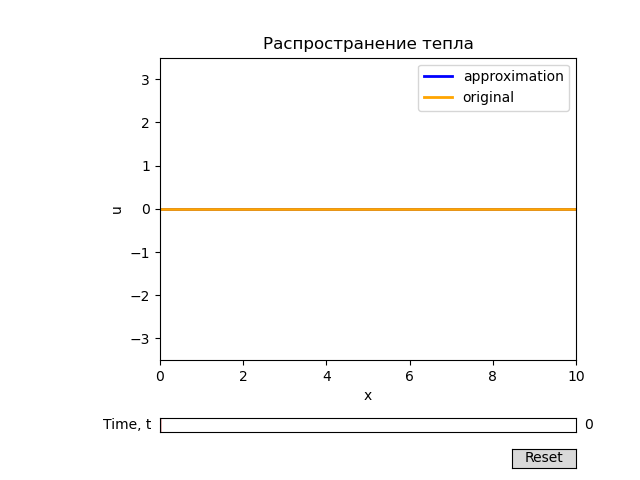

In [11]:
fig, ax  = plt.subplots()
line1,   = plt.plot(x_plot, u_plot1[0], lw = 2, color = 'blue',   label='approximation')
line2,   = plt.plot(x_plot, u_plot[0],  lw = 2, color = 'orange', label='original')

plt.xlim(0, 10)
plt.ylim(-3.5, 3.5)

plt.subplots_adjust(left = 0.25, bottom = 0.25)

ax_time = plt.axes([0.25, 0.1, 0.65, 0.03])
time_slider = Slider(
    ax      = ax_time,
    label   = 'Time, t',
    valmin  = t0,
    valmax  = T,
    valinit = 0,
    valstep = t,
    color   = 'gray'
)

time_slider.on_changed(update)


resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button  = Button(resetax, 'Reset', hovercolor='0.975')

button.on_clicked(reset)


ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_title("Распространение тепла")

ax.legend()

plt.show()

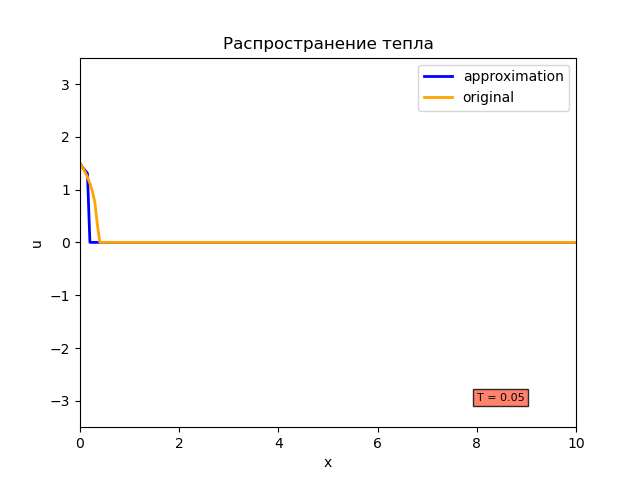

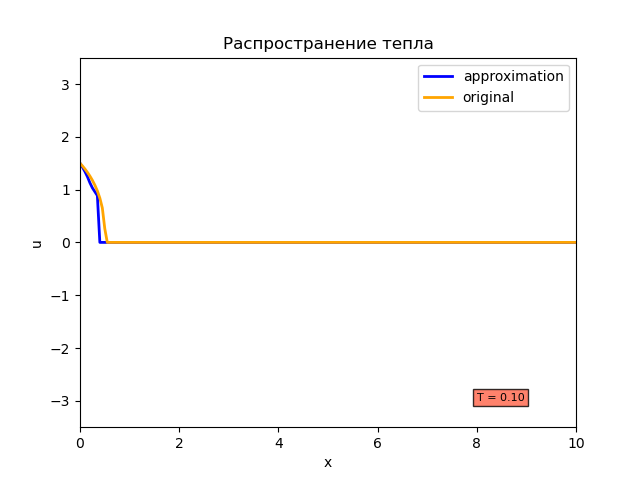

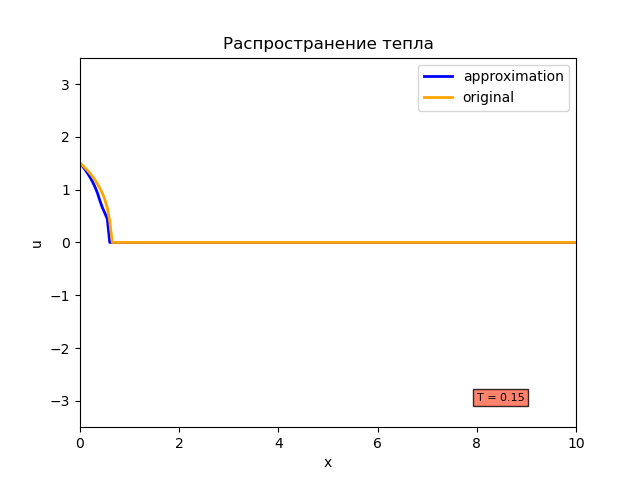

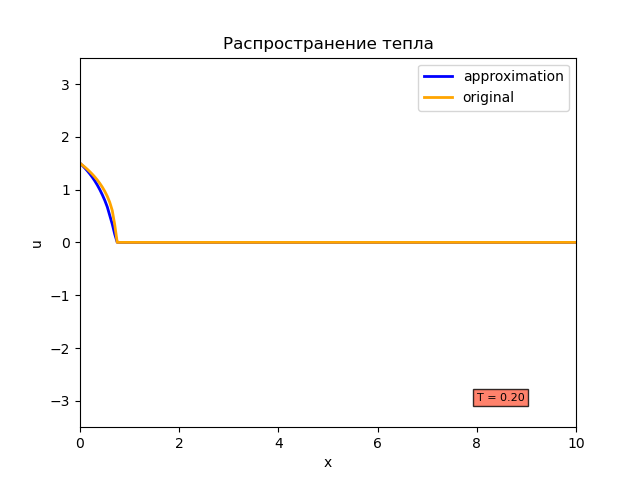

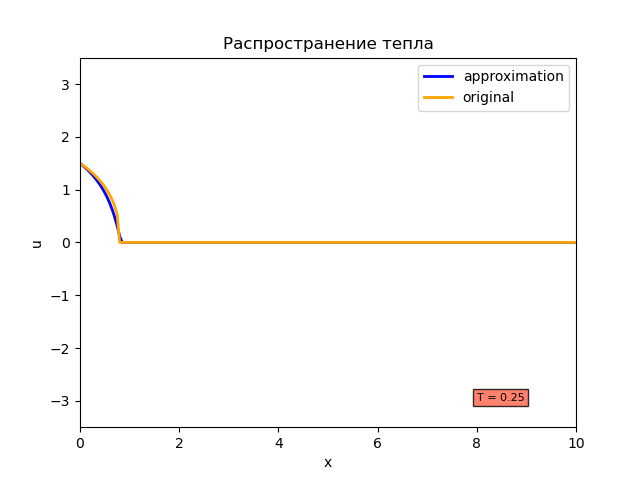

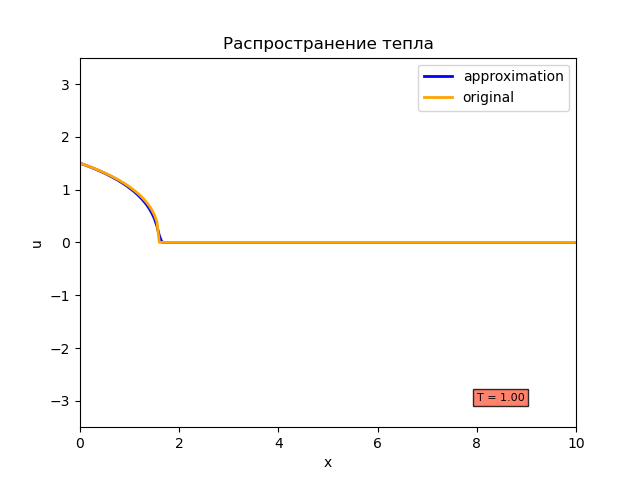

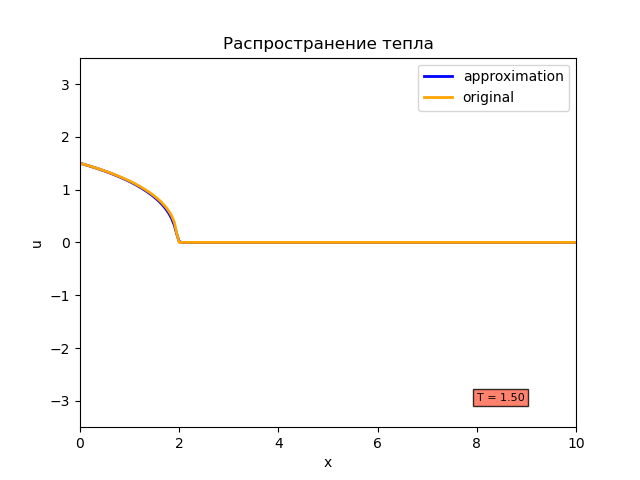

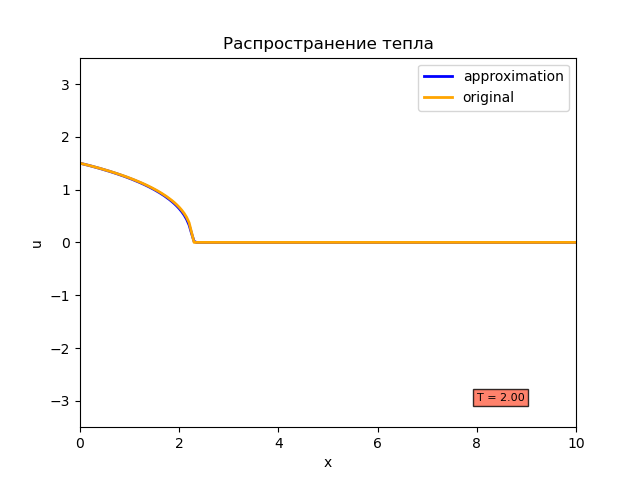

In [12]:
# t от 0.05 до 0.5 с шагом 0.05

for i in range(1,6):
    graph(x_plot, u_plot, u_plot1, i)
        
# t от 1 до 2 с шагом 0.5
    
for i in range(20, 50, 10):
    graph(x_plot, u_plot, u_plot1, i)